<a href="https://colab.research.google.com/github/AmitAaranya/ASL-Recognition-with-CNN-PyTorch/blob/main/google-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone GitHub repo
**URL:** https://github.com/AmitAaranya/ASL-Recognition-with-Deep-Learning-PyTorch

In [1]:
!git clone https://github.com/AmitAaranya/ASL-Recognition-with-Deep-Learning-PyTorch.git ./code/

Cloning into './code'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 122 (delta 53), reused 72 (delta 20), pack-reused 0
Receiving objects: 100% (122/122), 2.63 MiB | 14.79 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
!git config --global user.email "amitaaranya@gmail.com"
!git config --global user.name "AMIT"

In [ ]:
!git --git-dir=./code/.git commit -m "Model save"

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    .gitignore
	deleted:    README.md
	deleted:    asl-image-labels.png
	deleted:    data-set-distribution.png
	deleted:    data_loader.py
	deleted:    google-colab.ipynb
	deleted:    notebook.ipynb
	deleted:    requirements.txt

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.config/
	asl_cnn_model.pth
	code/
	datasets/
	sample_data/
	synthetic-asl-alphabet.zip

no changes added to commit (use "git add" and/or "git commit -a")


In [2]:
## Add the folder to system path, so we can import file directly
import sys
sys.path.append('/content/code')

In [ ]:
!pip install -r code/requirements.txt > /dev/null

ERROR: Operation cancelled by user


In [ ]:
!pip install kaggle

# Load the ASL Image Data
**URL:** https://www.kaggle.com/datasets/lexset/synthetic-asl-alphabet


In [ ]:
!echo "{\"username\":\"amitaaranya\",\"key\":\"e8845441bb41bfd733339ef7c8f50fa\"}" > /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d lexset/synthetic-asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/lexset/synthetic-asl-alphabet
License(s): copyright-authors
100% 6.57G/6.58G [01:14<00:00, 168MB/s]
100% 6.58G/6.58G [01:14<00:00, 94.6MB/s]


In [4]:
!mkdir datasets

In [5]:
!unzip synthetic-asl-alphabet.zip -d ./datasets/ > /dev/null

# Exploratory Data Analysis(EDA)

In [6]:
# Imports
import torch
import numpy as np

## Load Data

In [7]:
from data_loader import load_datasets

size = 100
x_train, y_train = load_datasets(size = size)
x_test,  y_test = load_datasets(train_or_test_folder="Test_Alphabet",size = size)

print(f"Train dataset count: {len(x_train)} \nTest dataset count: {len(x_test)} ")

Loading datasets:  A B Blank C D E F G H I J K L M N O P Q R S T U V W X Y Z 

Loading datasets:  A B Blank C D E F G H I J K L M N O P Q R S T U V W X Y Z 

Train dataset count: 24300 
Test dataset count: 2700 


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
from data_loader import alphabet_to_num

def one_hot_coding(unique_labels, data):
    y_oh = torch.zeros(len(data),unique_labels)
    for i, class_word in enumerate(data):
        index = alphabet_to_num(class_word)
        y_oh[i][index] = 1

    return y_oh
y_train,y_test = np.array(y_train),np.array(y_test)
y_train_oh = one_hot_coding(len(np.unique(y_train)),y_train)
y_test_oh = one_hot_coding(len(np.unique(y_train)),y_test)

In [ ]:
x_train.shape,y_train.shape

(torch.Size([24300, 3, 100, 100]), (24300,))

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=27, kernel_size=5, padding=2)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=4, stride=4)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=27, out_channels=27, kernel_size=5, padding=2)
        # Another max pooling layer
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer
        self.fc1 = nn.Linear(27 * 12 * 12, 270)  # 3x3 is the size after two max pooling layers
        self.dropout = nn.Dropout(p = 0.5)
        self.fc2 = nn.Linear(270,27)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 27 * 12 * 12)  # Flatten the output of conv2 layer
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = ConvNet()

# Print the model architecture
print(model)

ConvNet(
  (conv1): Conv2d(3, 27, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(27, 27, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3888, out_features=270, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=270, out_features=27, bias=True)
)


In [22]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.9)
batch_size = 32

x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_oh_tensor = torch.tensor(y_train_oh, dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_oh_tensor = torch.tensor(y_test_oh, dtype=torch.float32).to(device)

train_loader = DataLoader(TensorDataset(x_train_tensor,y_train_oh_tensor),
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_tensor,y_test_oh_tensor),
                          batch_size=batch_size)

<ipython-input-22-cb26553e68c2>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
<ipython-input-22-cb26553e68c2>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_oh_tensor = torch.tensor(y_train_oh, dtype=torch.float32).to(device)
<ipython-input-22-cb26553e68c2>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
<ipython-input-22-cb26553e68c2>:14: UserWarning: To copy construct from a tensor,

In [23]:
len(train_loader.dataset),len(test_loader.dataset)

(24300, 2700)

In [24]:
print(train_loader.batch_size)

32


## Define CNN model

In [28]:
def train_model(model, criterion, optimizer, device, num_epochs=50):
    model.to(device)  # Move the model to the device outside the loop
    for epoch in range(num_epochs):
        running_loss = 0
        errorr = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device
            # print(f"Inputs size from train_loader: {inputs.size()}")  # Print sizes for debugging
            # print(f"Labels size from train_loader: {labels.size()}")
            optimizer.zero_grad()
            outputs = model(inputs)
            # print(f"Output Tensor size from Model: {outputs.size()}")
            _, predicted = torch.max(outputs, 1)
            _, labels_indices = torch.max(labels, 1)  # Convert one-hot labels to indices
            errorr += (predicted != labels_indices).sum().item()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        scheduler.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss}, Train Error: {(errorr/len(train_loader.dataset))*100}%")
        # Learnig rate:{scheduler.get_last_lr()}

# Call the function to train the model
train_model(model=model, criterion=criterion, optimizer=optimizer, device=device)

Epoch [1/50], Train Loss: 0.1142540606592663, Train Error: 3.8436213991769543%
Epoch [2/50], Train Loss: 0.11207585116718041, Train Error: 3.7654320987654324%
Epoch [3/50], Train Loss: 0.11292544849615528, Train Error: 3.7901234567901234%
Epoch [4/50], Train Loss: 0.1108759651642768, Train Error: 3.6790123456790123%
Epoch [5/50], Train Loss: 0.10667586941655281, Train Error: 3.5267489711934155%
Epoch [6/50], Train Loss: 0.1046370421785386, Train Error: 3.411522633744856%
Epoch [7/50], Train Loss: 0.10473984368636038, Train Error: 3.4650205761316872%
Epoch [8/50], Train Loss: 0.1034645004303735, Train Error: 3.3621399176954734%
Epoch [9/50], Train Loss: 0.10126285920908422, Train Error: 3.2098765432098766%
Epoch [10/50], Train Loss: 0.09820050366130877, Train Error: 3.251028806584362%
Epoch [11/50], Train Loss: 0.09677583270234826, Train Error: 3.246913580246914%
Epoch [12/50], Train Loss: 0.09553816542029381, Train Error: 3.1193415637860085%
Epoch [13/50], Train Loss: 0.095643010729686

In [29]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    test_labels,test_outputs = [],[]
    with torch.no_grad():
        for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          _, labels_indices = torch.max(labels, 1)  # Convert one-hot labels to indices
          test_labels += [a.cpu().tolist() for a in labels_indices]
          test_outputs += [b.cpu().tolist() for b in predicted]
          total += labels.size(0)
          correct += (predicted == labels_indices).sum().item()
    accuracy = correct / total
    print(f"Total accurate predictions: {correct} out of {total}")
    print(f"Accuracy on test set: {accuracy:.4f}")
    print(f"Test Error: {((total-correct)/total)*100}%")
    return test_labels,test_outputs

test_labels,test_outputs = test_model(model=model,test_loader=test_loader)

# Save the model
torch.save(model.state_dict(), 'code/asl_cnn_model.pth')

Total accurate predictions: 2441 out of 2700
Accuracy on test set: 0.9041
Test Error: 9.592592592592593%


In [ ]:
!pip install -U scikit-learn

In [ ]:
def num_to_char(array_data):
  lables = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
  return [lables[a] if a !=26 else "NONE" for a in array_data]



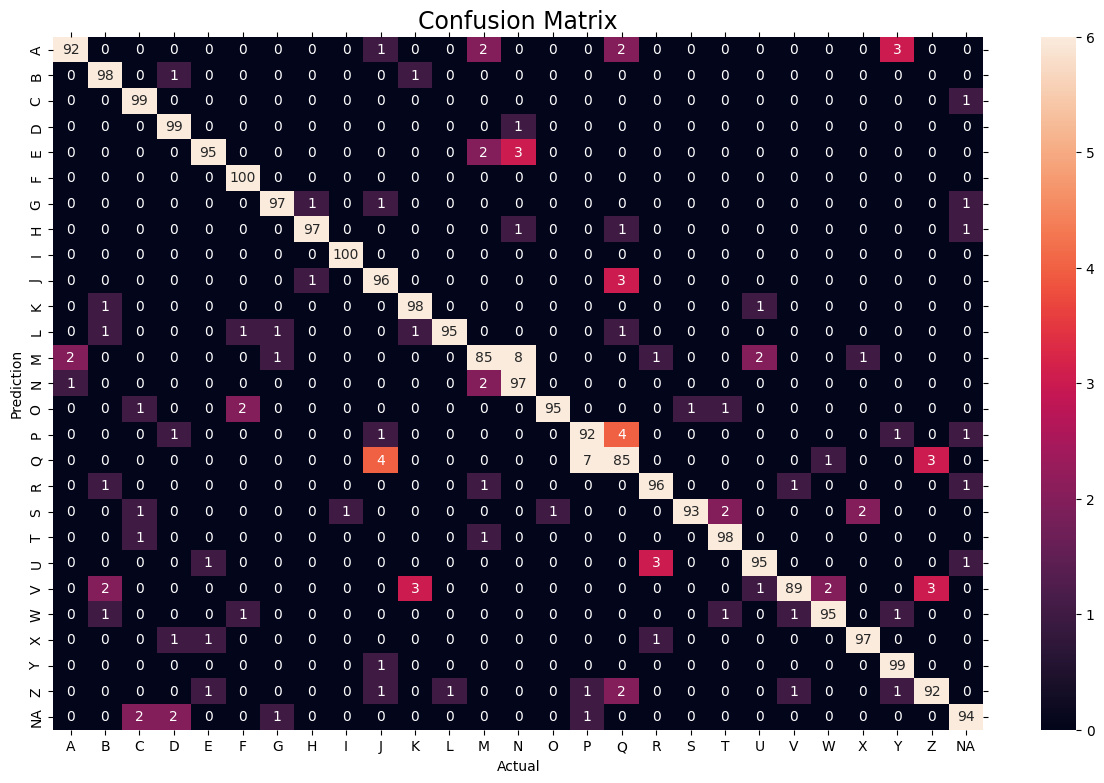

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels,test_outputs)
label_list = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")+ ["NA"]
plt.figure(figsize=(15, 9))
heatmap = sn.heatmap(cm,
           vmax = 6,
           annot=True,
           fmt="d",
           xticklabels=label_list,
           yticklabels = label_list

           )
heatmap.tick_params(top=True, bottom=True, left=True, right=True)
# Set labels and title
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.title('Confusion Matrix', fontsize=17)
plt.savefig("code/static/confusion_matrix.png")
plt.show()

In [18]:
from sklearn.metrics import classification_report

print(classification_report(test_labels,test_outputs))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       100
           1       0.94      0.98      0.96       100
           2       0.95      0.99      0.97       100
           3       0.95      0.99      0.97       100
           4       0.97      0.95      0.96       100
           5       0.96      1.00      0.98       100
           6       0.97      0.97      0.97       100
           7       0.98      0.97      0.97       100
           8       0.99      1.00      1.00       100
           9       0.91      0.96      0.94       100
          10       0.95      0.98      0.97       100
          11       0.99      0.95      0.97       100
          12       0.91      0.85      0.88       100
          13       0.88      0.97      0.92       100
          14       0.99      0.95      0.97       100
          15       0.91      0.92      0.92       100
          16       0.87      0.85      0.86       100
          17       0.95    

In [19]:
model.load_state_dict(torch.load('code/static/asl_cnn_model.pth'))
model.eval()


ConvNet(
  (conv1): Conv2d(3, 27, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(27, 27, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3888, out_features=27, bias=True)
)